# Calculate data for REZ regions

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '00:05:00'
cores = 24
memory = str(4 * cores) + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])
                     # python=os.environ["DASK_PYTHON"])

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.75.29:8787/status,
Dashboard: http://10.6.75.29:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.75.29:36509,Workers: 0
Dashboard: http://10.6.75.29:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
# client.close()
# cluster.close()

In [6]:
%load_ext autoreload
%autoreload 2

In [138]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'

In [8]:
import functions as fn

plt_params = fn.get_plot_params()

# Load REZ mask

In [9]:
rez_mask = xr.open_dataset(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/rez_mask_era5_grid.nc'
).REZ

# Load gridded data

In [10]:
years = range(1959, 2021)

Mean solar shortwave radiation downwards

In [11]:
mssrd = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/msdwswrf/msdwswrf_era5_reanalysis_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region.zarr',
    consolidated=True
)

100m wind speed

In [12]:
w100 = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/100w/100w_era5_reanalysis_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region.zarr',
    consolidated=True
)

# Calculate regional averages

In [13]:
def REZ_spatial_mean(da, region):
    region_mask = rez_mask.sel(region=region)
    return da.where(region_mask, drop=True).mean(['lat', 'lon'], skipna=True)

In [14]:
def calculate_spatial_means(da):
    
    da_list = []
    for region in rez_mask['region'].values:
        region_mean = REZ_spatial_mean(da, region)
        da_list.append(region_mean)
        
    da_concat = xr.concat(
        da_list,
        dim='region'
    )
    return da_concat

In [15]:
rez_100w = calculate_spatial_means(w100['w100']).compute()

In [16]:
rez_mssrd = calculate_spatial_means(mssrd['msdwswrf']).compute()

# How often to regional means exceed operational thresholds?

- For wind, we use 4 m/s (Ridder report)
- For solar, use 170 W/m^2 (Prasad 2021), or 95 W/m^2 (calculated from 342 kJ/hr in Ridder report using https://www.unitconverters.net/power/kilojoule-hour-to-watt.htm)

Calculate daily means
(Maybe we should use rolling 24 hours at some point)

In [205]:
daily_rez_100w = rez_100w.resample(time='1D').mean()

In [218]:
daily_rez_mssrd = rez_mssrd.resample(time='1D').mean()

In [222]:
thresh_100w = 4
thresh_mssrd = 170

In [199]:
def calculate_event_frequency(da, thresh, tail='lower',
                             time_name='time'):
    T = len(da[time_name].values)
            
    if tail == 'lower':
        freq = xr.where(da < thresh, 1, 0).sum(time_name) / T
            
    return freq

In [212]:
freq_100w = calculate_event_frequency(daily_rez_100w, thresh_100w)

In [223]:
freq_mssrd = calculate_event_frequency(daily_rez_mssrd, thresh_mssrd)

In [242]:
import math

def round_decimals_up(number:float, decimals:int=2):
    """
    Returns a value rounded up to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.ceil(number)

    factor = 10 ** decimals
    return math.ceil(number * factor) / factor

In [246]:
round_decimals_up(0.18, 1)

0.2

In [278]:
def plot_freq(da, region_codes=range(1,8), vmin=0, vmax='max'):
    
    import math
    def roundup(x):
        return int(math.ceil(x / 10.0)) * 10

    with plt.rc_context(plt_params):
        regions = [rez_mask.region.values[i] for i in range(len(rez_mask.region.values)) if
                   rez_mask.region_code.values[i] in region_codes]
        plot_da = xr.where(rez_mask.sel(region=regions),
                           da.sel(region=regions),
                           np.nan).sum('region', skipna=True)
        plot_da = plot_da.where(rez_mask.sel(region=regions).sum('region'))
        
        if vmax == 'max':
            data_max = plot_da.max().values
            if data_max > 0.2:
                vmax=round_decimals_up(data_max, 1)
                cbar_tick_intervals = 0.1
            else:
                vmax=round_decimals_up(data_max, 2)
                cbar_tick_intervals = 0.01

        fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)
        ax.coastlines()
        ax.add_feature(
            cartopy.feature.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces',
                                                scale='10m'),
            facecolor='none', edgecolor='k', lw=plt_params['lines.linewidth'] / 3
        )

        plot_da.plot(ax=ax, vmin=vmin, vmax=vmax,
                    cbar_kwargs={
                        'ticks': np.arange(vmin, vmax+.1, cbar_tick_intervals),
                        'label': 'Relative frequency [-]'
                    })

### Solar lulls

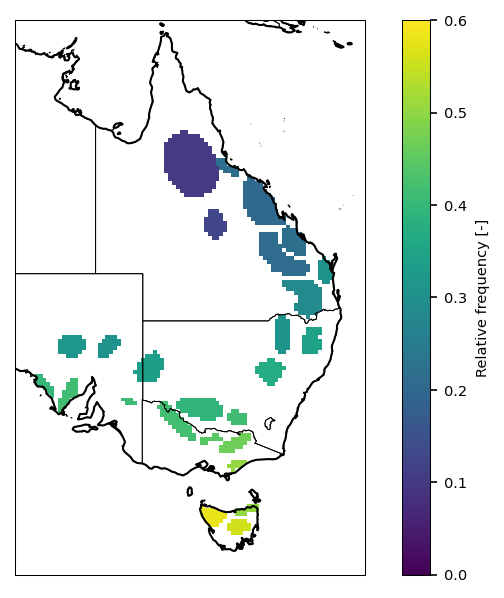

In [279]:
plot_freq(freq_mssrd, region_codes=[2, 3, 6, 7])

### Wind lulls

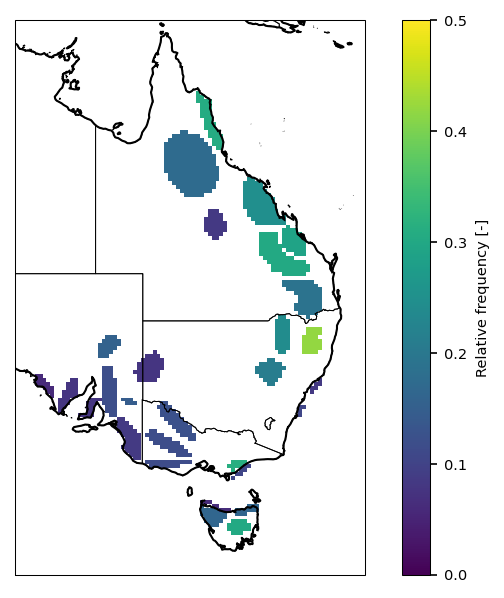

In [280]:
plot_freq(freq_100w, region_codes=[1, 3, 5, 7])

### Simultaneous wind and solar lulls

In [281]:
freq_100w_mssrd = xr.where(
    (daily_rez_100w < thresh_100w) &
    (daily_rez_mssrd < thresh_mssrd),
    1, 0
).sum('time') / len(daily_rez_100w.time.values)

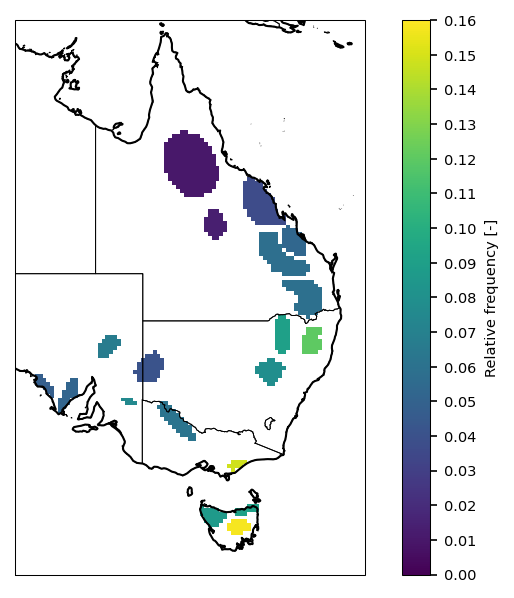

In [282]:
plot_freq(freq_100w_mssrd, region_codes=[3, 7])